# Séries temporais com Python

In [46]:
import numpy as np              # Python numérico
import pandas as pd             # Estrutura de dados
import matplotlib.pyplot as plt # Pacote gráfico 

In [69]:
#=================================================================================
# ATENÇÃO:
# Esta parte do código serve apenas para carregar os dados no google colaboration
# Abaixo será explicado como carregar os dados usando o jupyter
#=================================================================================

from google.colab import files
uploaded = files.upload()

In [70]:
#=================================================================================
# ATENÇÃO:
# Esta parte do código serve apenas para carregar os dados no google colaboration
# Abaixo será explicado como carregar os dados usando o jupyter
#=================================================================================

import io
dados = pd.read_csv(io.StringIO(uploaded['PIB.csv'].decode('utf-8')))

## 1. Carregando os dados

Podemos carregar os dados de um arquivo do computador em diversos formatos. O código a seguir mostra como carregar os dados de um arquivo xlsx usando a biblioteca **pandas**.

Obs.: Os dados ficam no formato DataFrame quando importado desta forma.

In [71]:
#dados = pd.read_excel('/home/cassio/Documents/Estágio Docência/PIB.xlsx')

p = pd.period_range(start="1995-01", end="2018-01", freq="Q-DEC") # Cria um índice no formato ano/mes de 3 em 3 meses

p = p.to_timestamp(how='end') # Converte para timestamp (último dia de cada trimestre)

dados.index = p # Configura o índice do DataFrame como os períodos do objeto p

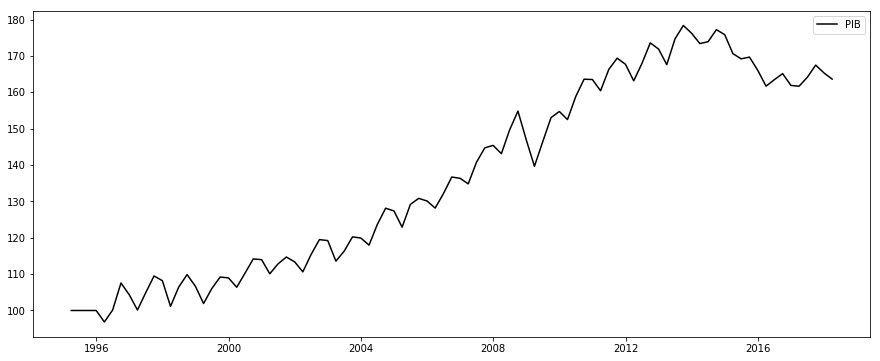

In [50]:
# Plota a série do PIB nominal

plt.figure(figsize=(15,6)) # Tamanho da figura

plt.plot(dados.index, dados['PIB'],
        color="black", label="PIB")
plt.legend() # legenda
plt.show()

In [51]:
dados["PIB"].describe()

count     93.000000
mean     136.963548
std       26.533898
min       96.840000
25%      110.630000
50%      134.840000
75%      163.630000
max      178.420000
Name: PIB, dtype: float64

In [52]:
dados['PIB'].max()
np.mean(dados['PIB'])

136.96354838709678

In [53]:
# Selecionando os dados a partir de 1996
y = dados['PIB'][4:]
data96 = np.arange('1996-01', '2018-04', dtype='datetime64[3M]')

## 2. Transformações nos dados

Quando trabalhamos com séries temporais, usualmente queremos modelar séries estacionárias.

In [54]:
import statsmodels
from statsmodels.tsa.stattools import adfuller

adf = adfuller(dados['PIB'])

print('ADF Statistic: %f' % adf[0])
print('p-value: %f' % adf[1])
print('Critical Values:')
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.613535
p-value: 0.476120
Critical Values:
	1%: -3.515
	5%: -2.898
	10%: -2.586


In [55]:
# Primeira diferença

dy = y.diff(periods=1).dropna()
gt = np.log(y).diff(periods=1).dropna()
ga = np.log(y).diff(periods=4).dropna()

# Estatística descritiva
ga.describe()

count    85.000000
mean      0.022623
std       0.030536
min      -0.057453
25%       0.004543
50%       0.024554
75%       0.044683
max       0.088079
Name: PIB, dtype: float64

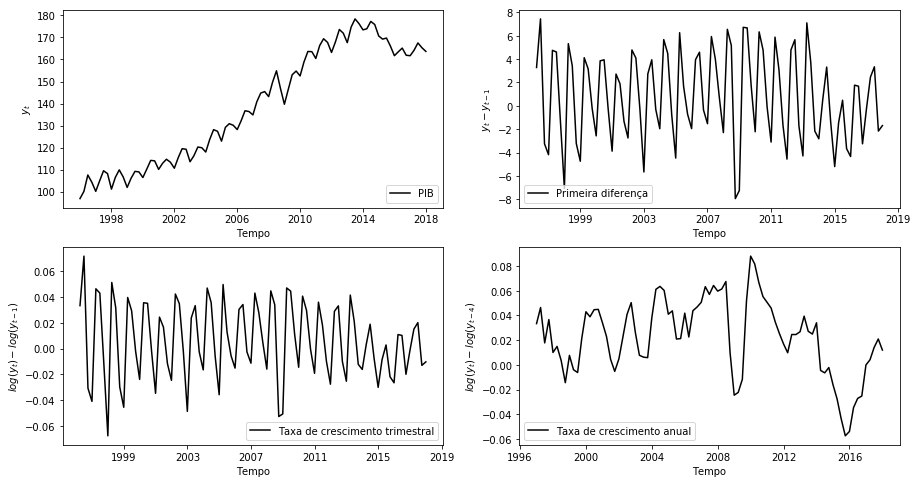

In [143]:
# Gráfico das 4 séries

fig = plt.figure(figsize=(15,8))

painel_1 = fig.add_subplot(2, 2, 1) # 2 linhas, 2 colunas, ocupa posição 1 
plt.plot(data96, y, color="black", label="PIB")
plt.xlabel("Tempo")
plt.ylabel("$y_t$")
plt.legend(loc="lower right") # Plota legenda e define a localização

painel_2 = fig.add_subplot(2, 2, 2) # 2 linhas, 2 colunas, ocupa posição 2
plt.plot(data96[1:], dy, color="black", label="Primeira diferença" )
plt.xlabel("Tempo")
plt.ylabel("$y_t - y_{t-1}$")
plt.legend(loc="lower left") # Plota legenda e define a localização

painel_3 = fig.add_subplot(2, 2, 3) # 2 linhas, 2 colunas, ocupa posição 3
plt.plot(data96[1:], gt, color="black", label="Taxa de crescimento trimestral")
plt.xlabel("Tempo")
plt.ylabel("$log(y_t) - log(y_{t-1})$")
plt.legend(loc="lower right")

painel_4 = fig.add_subplot(2, 2, 4) # 2 linhas, 2 colunas, ocupa posição 4
plt.plot(data96[4:], ga, color="black", label="Taxa de crescimento anual")
plt.xlabel("Tempo")
plt.ylabel("$log(y_t) - log(y_{t-4})$")
plt.legend(loc="lower left")

plt.savefig('figura.pdf')

In [57]:
# Vamos trabalhar com a variável taxa de crescimento anual e denotá-la por Y

Y = ga.dropna()
Y.describe()

count    85.000000
mean      0.022623
std       0.030536
min      -0.057453
25%       0.004543
50%       0.024554
75%       0.044683
max       0.088079
Name: PIB, dtype: float64

## 3. Função autocorrelação e função autocorelação parcial

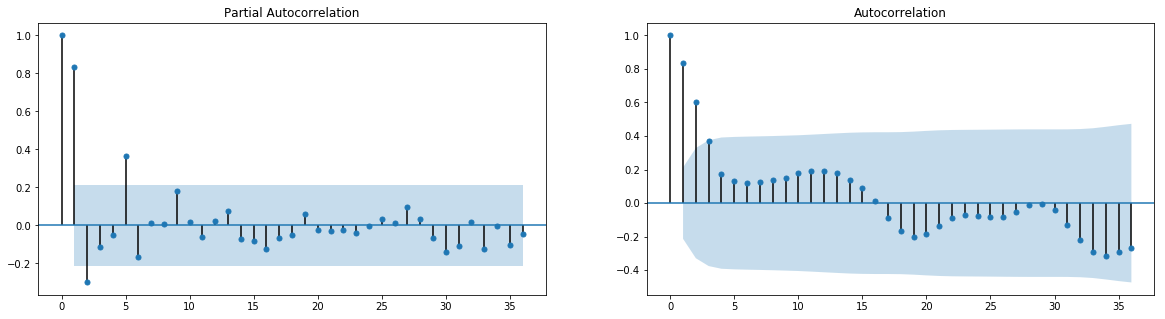

In [120]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


fig, ax = plt.subplots(1, 2, figsize=(20,5))

plot_pacf(Y, lags=36, ax=ax[0].axes, alpha=0.05)
plot_acf(Y, lags=36, ax=ax[1].axes, alpha=0.05)

plt.show()
#plt.savefig()

1997-03-31         NaN
1997-06-30    0.013038
1997-09-30   -0.028663
1997-12-31    0.018922
1998-03-31   -0.026670
1998-06-30    0.004916
1998-09-30   -0.011397
1998-12-31   -0.017983
1999-03-31    0.022110
1999-06-30   -0.011635
1999-09-30   -0.002255
1999-12-31    0.027634
2000-03-31    0.021591
2000-06-30   -0.004083
2000-09-30    0.005749
2000-12-31    0.000268
2001-03-31   -0.010767
2001-06-30   -0.011140
2001-09-30   -0.018500
2001-12-31   -0.009821
2002-03-31    0.010080
2002-06-30    0.017895
2002-09-30    0.018212
2002-12-31    0.009484
2003-03-31   -0.024077
2003-06-30   -0.018548
2003-09-30   -0.001511
2003-12-31   -0.000403
2004-03-31    0.032154
2004-06-30    0.023188
                ...   
2010-12-31   -0.011470
2011-03-31   -0.004687
2011-06-30   -0.004671
2011-09-30   -0.011236
2011-12-31   -0.009358
2012-03-31   -0.008423
2012-06-30   -0.007121
2012-09-30    0.014793
2012-12-31   -0.000050
2013-03-31    0.002290
2013-06-30    0.012613
2013-09-30   -0.012243
2013-12-31 

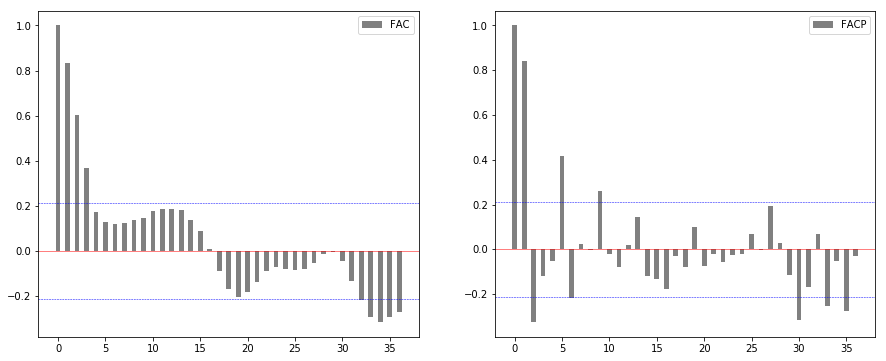

In [136]:
from statsmodels.tsa import stattools

fac  = stattools.acf(Y, nlags=36)
facp = stattools.pacf(Y, nlags=36)


index = list(range(len(fac)))

fig = plt.figure(figsize=(15,6))

painel_1 = fig.add_subplot(1,2,1)
plt.bar(index, fac, width=0.5, color='grey', label="FAC")
#plt.stem(index, fac, color='grey', label="FAC")
plt.axhline(0, color='red', lw=0.5)
plt.axhline((1.96/np.sqrt(len(Y))), color='blue', linestyle = "--", lw=0.5)
plt.axhline(-(1.96/np.sqrt(len(Y))), color='blue', linestyle = "--", lw=0.5)
plt.legend(loc="upper right")


painel_2 = fig.add_subplot(1,2,2)

plt.bar(index, facp, width=0.5, color='grey', label="FACP")

plt.axhline(0, color='red', lw=0.5)
plt.axhline((1.96/np.sqrt(len(Y))), color='blue', linestyle = "--", lw=0.5)
plt.axhline(-(1.96/np.sqrt(len(Y))), color='blue', linestyle = "--", lw=0.5)
plt.legend(loc="upper right")
plt.savefig('facp.pdf')
plt.show()

## 4.  Modelo AR(1)

In [60]:
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings("ignore",category=FutureWarning)

In [61]:
modelo = ARIMA(Y, order=(1,0,0))
modelo_fit = modelo.fit(trend='c')

In [62]:
print(modelo_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                    PIB   No. Observations:                   85
Model:                     ARMA(1, 0)   Log Likelihood                 226.443
Method:                       css-mle   S.D. of innovations              0.017
Date:                Wed, 15 Aug 2018   AIC                           -446.886
Time:                        15:10:50   BIC                           -439.558
Sample:                    03-31-1997   HQIC                          -443.938
                         - 03-31-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0226      0.010      2.285      0.025       0.003       0.042
ar.L1.PIB      0.8261      0.058     14.190      0.000       0.712       0.940
                                    Roots           

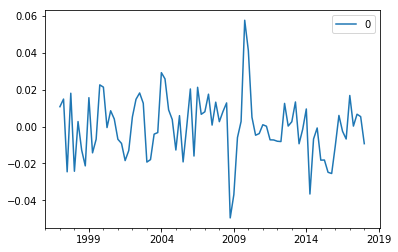

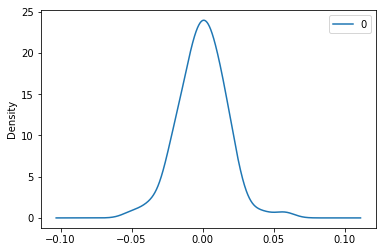

               0
count  85.000000
mean   -0.000105
std     0.016871
min    -0.049513
25%    -0.009266
50%     0.000265
75%     0.009542
max     0.057644


In [63]:
# Plotando os resíduos
residuals = pd.DataFrame(modelo_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

## 5. Previsão

In [64]:
yhat, std, IC = modelo_fit.forecast(steps=20, exog=None, alpha=0.05)

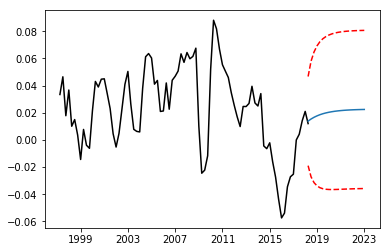

In [65]:
passos = pd.period_range(start="2018-02", end="2022-12", freq="Q-DEC") # Cria um índice no formato ano/mes de 3 em 3 meses

passos = passos.to_timestamp(how='end') # Converte para timestamp (último dia de cada trimestre)

yhat = pd.DataFrame(yhat)
yhat.index = passos
IC = pd.DataFrame(IC)
IC.index = passos

plt.plot(Y, color='black')
plt.plot(yhat)
plt.plot(IC, '--', color='red')
plt.show()

In [66]:
X = Y.values

tamanho = 65
amostra  = X[0:tamanho]
teste   = X[tamanho:len(X)]

janela = [x for x in amostra]
predict  = list()
intervalo= list()

for t in range(len(teste)):
    modelo = ARIMA(janela, order=(1,0,0))
    ajuste = modelo.fit()
    
    yhat, std, IC = ajuste.forecast()
    predict.append(yhat)
    intervalo.append(IC)
    
    obs = teste[t]
    janela.append(obs)
    print('Previsão=%f, Observado=%f' % (yhat, obs))
    

Previsão=0.028103, Observado=0.039457
Previsão=0.037349, Observado=0.027214
Previsão=0.028401, Observado=0.024931
Previsão=0.026711, Observado=0.034073
Previsão=0.033378, Observado=-0.004474
Previsão=0.005314, Observado=-0.006466
Previsão=0.003382, Observado=-0.002158
Previsão=0.006282, Observado=-0.016041
Previsão=-0.004813, Observado=-0.027450
Previsão=-0.014748, Observado=-0.043524
Previsão=-0.029532, Observado=-0.057453
Previsão=-0.043705, Observado=-0.053924
Previsão=-0.041909, Observado=-0.034566
Previsão=-0.025111, Observado=-0.027175
Previsão=-0.019069, Observado=-0.025247
Previsão=-0.017726, Observado=-0.000062
Previsão=0.003814, Observado=0.004151
Previsão=0.007304, Observado=0.014068
Previsão=0.015597, Observado=0.020962
Previsão=0.021352, Observado=0.011986


In [67]:
passos = pd.period_range(start="2013-06", end="2018-03", freq="Q-DEC") # Cria um índice no formato ano/mes de 3 em 3 meses
passos = passos.to_timestamp(how='end') # Converte para timestamp (último dia de cada trimestre)


teste = pd.DataFrame(teste)
teste.index = passos

predict = pd.DataFrame(predict)
predict.index = passos

intervalo = pd.DataFrame(np.squeeze(intervalo))
intervalo.index = passos

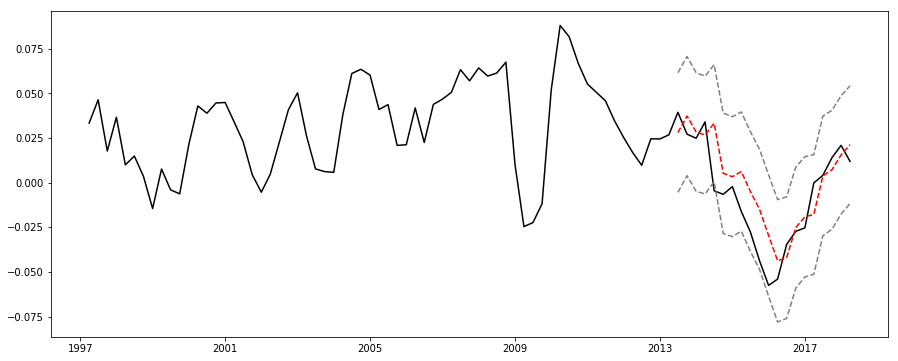

In [68]:

plt.figure(figsize=(15,6))
plt.plot(Y, color='black', label='Verdadeiro')
plt.plot(predict,'--', color='red', label="Previsto")
plt.plot(intervalo, '--', color='grey')
plt.show()

## Quandl: Carregando dados da internet

Uma outra forma de carregar dados é usando uma biblioteca que puxa os dados de algumas fontes principais. Em python, a biblioteca **quandl** permite acessar os dados do BCB, bem como outras base de dados de bancos centrais (por exemplo, FRED).

In [ ]:
# Alternativa ao BETS do R

#============================================================================================================
# ATENÇÃO:
# se estiver usando o python no google collabortory, rodar a seguinte linha na primeira vez que rodar em seu
# computador:

#!pip install quandl

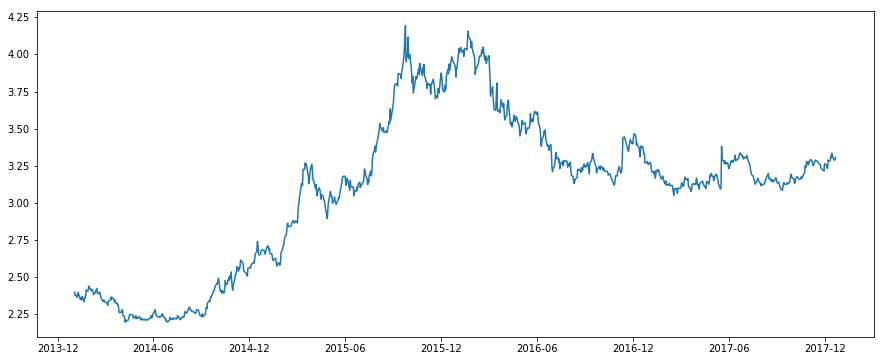

In [44]:
import quandl
dol = quandl.get("BCB/1", start_date='2014-01-01', end_date='2017-12-21')
plt.figure(figsize=(15,6))
plt.plot(dol)
plt.show()

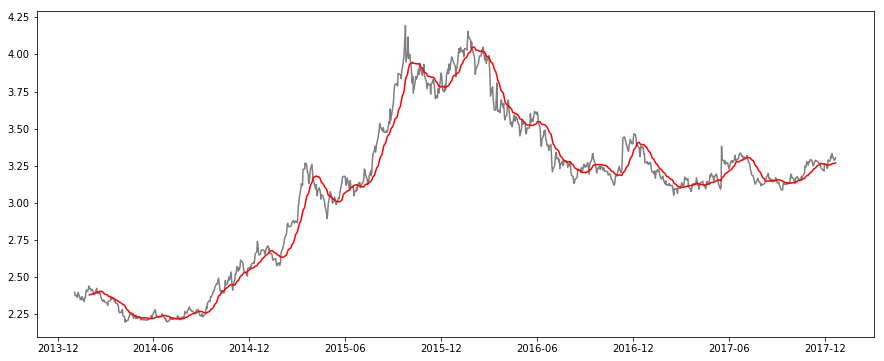

In [45]:
plt.figure(figsize=(15,6))
r = dol.rolling(window=21)
plt.plot(dol, 'k-', alpha=0.5)
plt.plot(r.mean(),'r-')
plt.show()

# Note que a média varia ao longo do tempo. Portanto, não é estacionária. Vamos trabalhar com o log retorno

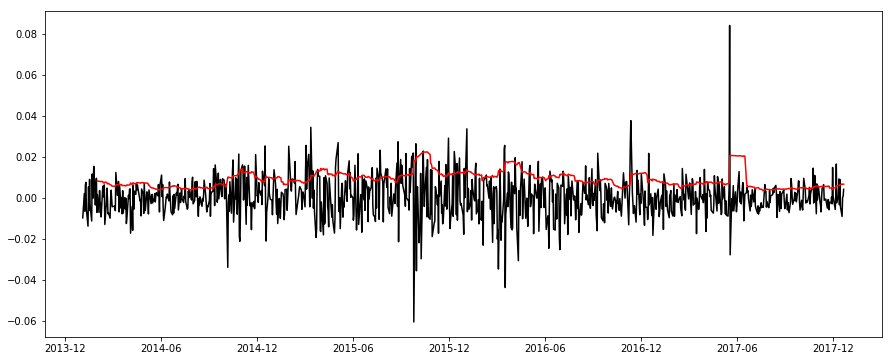

In [43]:
dol_ret = np.log(dol).diff().dropna()
rr = dol_ret.rolling(window=21)
plt.figure(figsize=(15,6))
plt.plot(dol_ret, color='black')
plt.plot(rr.std(), color='red')
plt.show()